# R INTERFACE TO CAS DEMONSTRATION

## Overview of the Predictive Modeling Case
A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# DATA MINING WORKFLOW

## Load Necessary Packages

In [258]:
library(swat)
library(ggplot2)
library(reshape2)
library(xgboost)
library(caret)

## Connect to the CAS Server

In [259]:
#CAS(hostname,port,username,password)
conn <- CAS("server", 8777, "student", "Metadata0", protocol="http")

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).


## Read in the Dataset

In [260]:
castbl <- cas.read.csv(conn, "D:/Workshop/Winsas/AX17HRV/hmeq.csv")

#Create variable for Dataset name
indata <- 'hmeq'

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(student).


## Explore the Data

In [261]:
#Use the dim and names functions to view the table size and column names
dim(castbl)
names(castbl)

[1] 5960   13

[1] "BAD"     "LOAN"    "MORTDUE" "VALUE"   "REASON"  "JOB"     "YOJ"    
 [8] "DEROG"   "DELINQ"  "CLAGE"   "NINQ"    "CLNO"    "DEBTINC"

In [262]:
#Use head and tail function to view the first and last 6 observations
head(castbl)
tail(castbl)

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5955,0,88500,50240,94687,DebtCon,Other,16,0,0,214.4262,0,16,34.75116
5956,0,88800,53307,94058,DebtCon,Other,16,0,0,218.3050,0,15,34.24246
5957,0,88900,48919,93371,DebtCon,Other,15,0,1,205.6502,0,15,34.81826
5958,0,88900,57264,90185,DebtCon,Other,16,0,0,221.8087,0,16,36.11235
5959,0,89000,54576,92937,DebtCon,Other,16,0,0,208.6921,0,15,35.85997
5960,0,89200,54045,92924,DebtCon,Other,15,0,0,212.2797,0,15,35.55659


In [263]:
#Use summary function to get variable summary
summary(castbl)

NOTE: Added action set 'fedSql'.


      BAD              LOAN          MORTDUE                
 Min.   :0.0000   Min.   : 1100   Min.   :2063              
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.:46268             
 Median :0.0000   Median :16300   Median :65019             
 Mean   :0.1995   Mean   :18608   Mean   :73760.8171995589  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.:91491             
 Max.   :1.0000   Max.   :89900   Max.   :399550            
                                  NA's   :518               
     VALUE                     REASON          JOB      
 Min.   :8000              DebtCon:3928   Mgr    : 767  
 1st Qu.:66069             HomeImp:1780   Office : 948  
 Median :89235.5           NA's   : 252   Other  :2388  
 Mean   :101776.04874145                  ProfExe:1276  
 3rd Qu.:119831.5                         Sales  : 109  
 Max.   :855909                           Self   : 193  
 NA's   :112                              NA's   : 279  
      YOJ                      DEROG                    

## Visualize Numeric Variables Locally

Warning message:
"Removed 4740 rows containing non-finite values (stat_bin)."

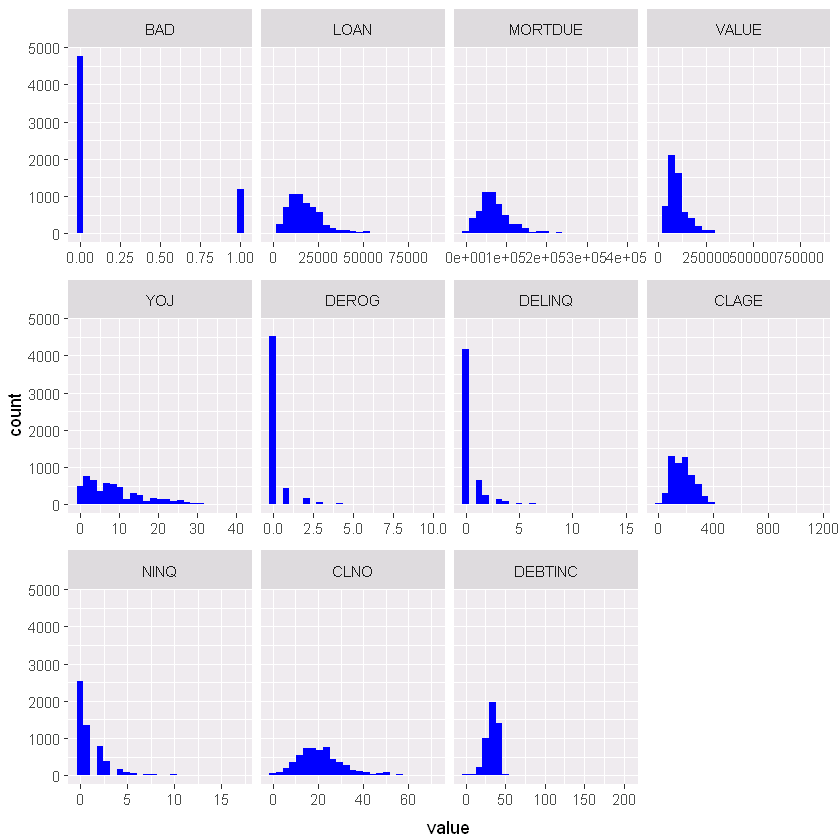

In [264]:
# Bring data locally
df <- to.casDataFrame(castbl, obs = nrow(castbl))

# Use reshape2's melt to help with data formatting
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)

#Plot data with ggplot
ggplot(d, aes(x = value)) +  facet_wrap(~variable,scales = 'free_x') + geom_histogram(fill = 'blue', bins = 25) 

## Check Data for Missing Values

In [265]:
tbl <- cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
tbl

Column,NMiss
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


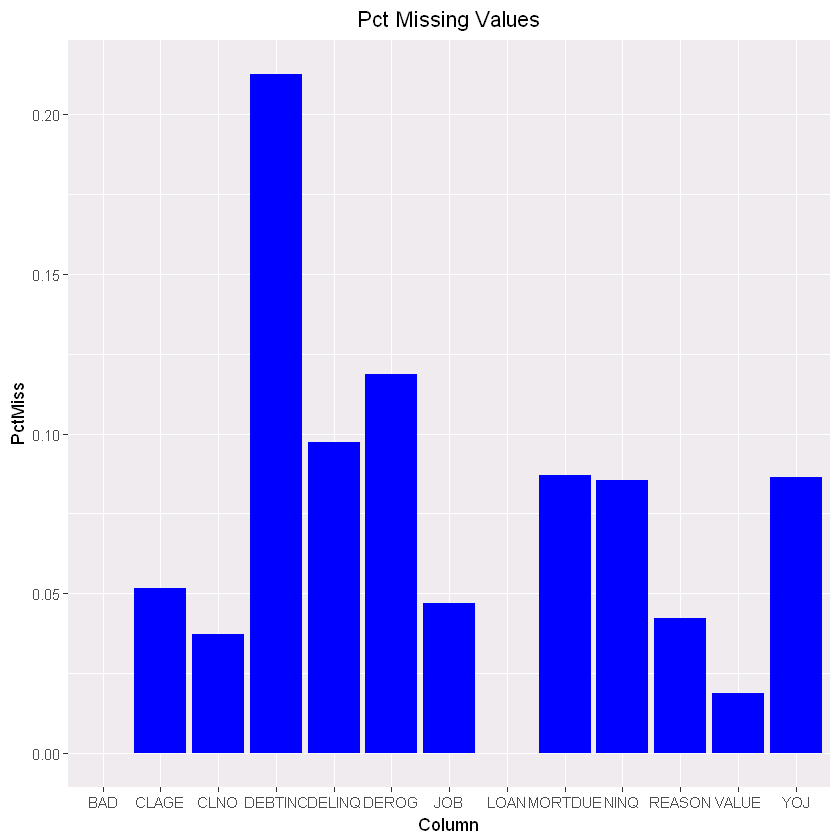

In [266]:
tbl$PctMiss <- tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) + geom_col(fill = 'blue') + 
   ggtitle('Pct Missing Values') + theme(plot.title = element_text(hjust = 0.5))

## Impute Missing Values

In [267]:
# Impute missing values with the median for continuous variables and most frequent for nominal variables
cas.dataPreprocess.impute(castbl,
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = colnames(castbl)[-1],
    copyAllVars      = TRUE,
    casOut           = list(name = indata, replace = TRUE)
)

Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,
NINQ,Median,IMP_NINQ,5450,510,1.00000,


## Split the Data into Training and Validation

In [268]:
# Load the sampling actionset
loadActionSet(conn, 'sampling')

NOTE: Added action set 'sampling'.
NOTE: Information for action set 'sampling':
NOTE:    sampling
NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more than three portions
NOTE:       stratified - Samples a proportion of data or partitions the data into no more than three portions within each stratum
NOTE:       oversample - Samples a user-specified proportion of data from the event level and adjusts the ratio between rare events and non-rare events to a user-specified ratio


In [269]:
# Partition the data
cas.sampling.srs(conn,
    table   = indata,
    samppct = 70,
    SEED=51188,
    partind = TRUE,
    output  = list(casOut = list(name = indata, replace = T), copyVars = 'ALL')
)

NOTE: Using SEED=51188 for sampling.


$OutputCasTables
            casLib Name Label Rows Columns
1 CASUSER(student) hmeq       5960      26

$SRSFreq
  NObs NSamp
1 5960  4172

$outputSize
$outputSize$outputNObs
[1] 5960

$outputSize$outputNVars
[1] 26

## Use SQL to view the partition

In [270]:
# Load the fedsql actionset
loadActionSet(conn, 'fedsql')

NOTE: Added action set 'fedsql'.
NOTE: Information for action set 'fedsql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution


In [271]:
# Make sure the partition worked correctly using SQL
cas.fedsql.execDirect(conn, query = paste0("
    SELECT 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END AS name,
        _PartInd_, 
        COUNT(*) AS obs 
    FROM ", indata, "
    GROUP BY 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END,
        _PartInd_;
"))

NAME,_PartInd_,OBS
Training,1,4172
Validation,0,1788


## Create Variable Shortcuts

In [272]:
# Get variable info and types
colinfo <- head(cas.table.columnInfo(conn, table = indata)$ColumnInfo, -1)
colinfo

# Target variable is the first column
target <- colinfo$Column[1]

# Get all variables
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

# Get only imputed variables
inputs <- grep('IMP_', inputs, value = T)
nominals <- c(target, grep('IMP_', nominals, value = T))

inputs
nominals

Column,Label,ID,Type,RawLength,FormattedLength,NFL,NFD
BAD,,1,double,8,12,0,0
LOAN,,2,double,8,12,0,0
MORTDUE,,3,double,8,12,0,0
VALUE,,4,double,8,12,0,0
REASON,,5,varchar,7,7,0,0
JOB,,6,varchar,7,7,0,0
YOJ,,7,double,8,12,0,0
DEROG,,8,double,8,12,0,0
DELINQ,,9,double,8,12,0,0
CLAGE,,10,double,8,12,0,0


[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# Model Building

## Decision Tree

In [273]:
# Load the decsion tree actionset
loadActionSet(conn, 'decisionTree')

NOTE: Added action set 'decisionTree'.
NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Train a decision tree
NOTE:       dtreeScore - Score a table using a decision tree model
NOTE:       dtreeSplit - Split decision tree nodes
NOTE:       dtreePrune - Prune a decision tree
NOTE:       dtreeMerge - Merge decision tree nodes
NOTE:       dtreeCode - Generate DATA step scoring code from a decision tree model
NOTE:       forestTrain - Train a forest
NOTE:       forestScore - Score a table using a forest model
NOTE:       forestCode - Generate DATA step scoring code from a forest model
NOTE:       gbtreeTrain - Train a gradient boosting tree
NOTE:       gbtreeScore - Score a table using a gradient boosting tree model
NOTE:       gbtreecode - Generate DATA step scoring code from a gradient boosting tree model


In [274]:
# Train the decision tree model
cas.decisionTree.dtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    varImp   = TRUE,
    casOut   = list(name = 'dt_model', replace = TRUE)
)

$DTreeVarImpInfo
     Variable Importance Std Count
1  IMP_DELINQ  50.131706   0     1
2 IMP_DEBTINC  35.264441   0     1
3   IMP_DEROG  14.500314   0     1
4    IMP_CLNO  13.249870   0     1
5   IMP_VALUE   9.313573   0     1

$ModelInfo
                          Descr      Value
1          Number of Tree Nodes   11.00000
2        Max Number of Branches    2.00000
3              Number of Levels    6.00000
4              Number of Leaves    6.00000
5                Number of Bins   20.00000
6        Minimum Size of Leaves    7.00000
7        Maximum Size of Leaves 4078.00000
8           Number of Variables   12.00000
9  Confidence Level for Pruning    0.25000
10  Number of Observations Used 4172.00000
11  Misclassification Error (%)   17.95302

$OutputCasTables
            casLib     Name Rows Columns
1 CASUSER(student) dt_model   11      27

## Random Forest

In [275]:
# Train the random forest model
cas.decisionTree.forestTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'rf_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.00000
Number of Selected Variables (M),4.00000
Random Number Seed,0.00000
Bootstrap Percentage (%),63.21206
Number of Bins,20.00000
Number of Variables,12.00000
Confidence Level for Pruning,0.25000
Max Number of Tree Nodes,25.00000
Min Number of Tree Nodes,11.00000
Max Number of Branches,2.00000


## Gradient Boosting

In [276]:
# Train the gradient boosting model
cas.decisionTree.gbtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'gbt_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.0
Distribution,2.0
Learning Rate,0.1
Subsampling Rate,0.5
Number of Selected Variables (M),12.0
Number of Bins,20.0
Number of Variables,12.0
Max Number of Tree Nodes,61.0
Min Number of Tree Nodes,23.0
Max Number of Branches,2.0


## Neural Network

In [277]:
# Load the neuralNet actionset
loadActionSet(conn, 'neuralNet')

NOTE: Added action set 'neuralNet'.
NOTE: Information for action set 'neuralNet':
NOTE:    neuralNet
NOTE:       annTrain - Train an artificial neural network
NOTE:       annScore - Score a table using an artificial neural network model
NOTE:       annCode - Generate DATA step scoring code from an artificial neural network model


In [278]:
# Build a neural network model
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'nn_model', replace = TRUE)
)

$ConvergenceStatus
                                          Reason
1 The optimization exited on maximum iterations.

$ModelInfo
                         Descr        Value
1                        Model   Neural Net
2  Number of Observations Used         4172
3  Number of Observations Read         4172
4     Target/Response Variable          BAD
5              Number of Nodes           20
6        Number of Input Nodes           18
7       Number of Output Nodes            2
8       Number of Hidden Nodes            0
9  Number of Weight Parameters           18
10   Number of Bias Parameters            2
11                Architecture         GLIM
12       Number of Neural Nets            1
13             Objective Value 1.5710806577

$OptIterHistory
   Progress Objective     Loss
1         1  5.629505 5.629505
2         2  3.083281 3.083281
3         3  1.711886 1.711886
4         4  1.639309 1.639309
5         5  1.599618 1.599618
6         6  1.586140 1.586140
7         7  1.575248 1.575248
8         8  1.574480 1.574480
9         9  1.571483 1.571483
10       10  1.571081 1.571081

$OutputCasTables
            casLib     Name Rows Columns
1 CASUSER(student) nn_model   20      15

## Score the Models

In [279]:
#Create table object for the imputed and partitioned data
pardata = defCasTable(conn, indata)

#Score the decision tree model
dt_score_obj = cas.decisionTree.dtreeScore(
   pardata[pardata$`_PartInd_` == 0,],
   model = "dt_model",
   casout = list(name="dt_scored",replace=TRUE),
   copyVars = list(target),
   encodename = TRUE,
   assessonerow = TRUE
)

#Score the random forest model
rf_score_obj = cas.decisionTree.forestScore(
   pardata[pardata$`_PartInd_` == 0,],
   model = "rf_model",
   casout = list(name="rf_scored",replace=TRUE),
   copyVars = list(target),
   encodename = TRUE,
   assessonerow = TRUE
)

#Score the gradient boosting model
gbt_score_obj = cas.decisionTree.gbtreeScore(
   pardata[pardata$`_PartInd_` == 0,],
   model = "gbt_model",
   casout = list(name="gbt_scored",replace=TRUE),
   copyVars = list(target),
   encodename = TRUE,
   assessonerow = TRUE
)

#Score the neural network model
nn_score_obj = cas.neuralNet.annScore(
   pardata[pardata$`_PartInd_` == 0,],
   model = "nn_model",
   casout = list(name="nn_scored",replace=TRUE),
   copyVars = list(target),
   encodename = TRUE,
   assessonerow = TRUE
)

#View selected fields from the output object
dt_score_obj$OutputCasTables
dt_score_obj$ScoreInfo

rf_score_obj$OutputCasTables
rf_score_obj$ScoreInfo

rf_score_obj$OutputCasTables
gbt_score_obj$ScoreInfo

rf_score_obj$OutputCasTables
nn_score_obj$ScoreInfo

casLib,Name,Rows,Columns
CASUSER(student),dt_scored,1788,13


Descr,Value
Number of Observations Read,1788
Number of Observations Used,1788
Misclassification Error (%),17.337807606


casLib,Name,Rows,Columns
CASUSER(student),rf_scored,1788,6


Descr,Value
Number of Observations Read,1788
Number of Observations Used,1788
Misclassification Error (%),17.281879195


casLib,Name,Rows,Columns
CASUSER(student),rf_scored,1788,6


Descr,Value
Number of Observations Read,1788
Number of Observations Used,1788
Misclassification Error (%),10.067114094


casLib,Name,Rows,Columns
CASUSER(student),rf_scored,1788,6


Descr,Value
Number of Observations Read,1788
Number of Observations Used,1788
Misclassification Error (%),15.436241611


# Assess the Models

In [280]:
# Load the percentile actionset for scoring
loadActionSet(conn, 'percentile')

NOTE: Added action set 'percentile'.
NOTE: Information for action set 'percentile':
NOTE:    percentile
NOTE:       percentile - Calculate quantiles and percentiles
NOTE:       boxPlot - Calculate quantiles, high and low whiskers, and outliers
NOTE:       assess - Assess and compare models


In [281]:
# Create table objects from the scoring output and assess each model

dt_scored = defCasTable(conn, tablename = "dt_scored")
cas.percentile.assess(
   dt_scored,
   inputs = paste("P_", target, "1", sep = ""),
   casout = list(name="dt_assess",replace=TRUE),
   response = target,
   event = "1"
)

rf_scored = defCasTable(conn, tablename = "rf_scored")
cas.percentile.assess(
   rf_scored,
   inputs = paste("P_", target, "1", sep = ""),
   casout = list(name="rf_assess",replace=TRUE),
   response = target,
   event = "1"
)

gbt_scored = defCasTable(conn, tablename = "gbt_scored")
cas.percentile.assess(
   gbt_scored,
   inputs = paste("P_", target, "1", sep = ""),
   casout = list(name="gbt_assess",replace=TRUE),
   response = target,
   event = "1"
)

nn_scored = defCasTable(conn, tablename = "nn_scored")
cas.percentile.assess(
   nn_scored,
   inputs = paste("P_", target, "1", sep = ""),
   casout = list(name="nn_assess",replace=TRUE),
   response = target,
   event = "1"
)

casLib,Name,Rows,Columns
CASUSER(student),dt_assess,20,21
CASUSER(student),dt_assess_ROC,100,20


casLib,Name,Rows,Columns
CASUSER(student),rf_assess,20,21
CASUSER(student),rf_assess_ROC,100,20


casLib,Name,Rows,Columns
CASUSER(student),gbt_assess,20,21
CASUSER(student),gbt_assess_ROC,100,20


casLib,Name,Rows,Columns
CASUSER(student),nn_assess,20,21
CASUSER(student),nn_assess_ROC,100,20


## Compare Confusion Matrix

In [282]:
#Create table objects from the assess output, 
#bring data to the client, 
#and add new variable to data frame indicating model name

dt_assess_ROC = defCasTable(conn, tablename = "dt_assess_ROC")
dt_assess_ROC <- to.casDataFrame(dt_assess_ROC, obs = nrow(dt_assess_ROC))
dt_assess_ROC$Model = 'Decision Tree'

rf_assess_ROC = defCasTable(conn, tablename = "rf_assess_ROC")
rf_assess_ROC <- to.casDataFrame(rf_assess_ROC, obs = nrow(rf_assess_ROC))
rf_assess_ROC$Model = 'Random Forest'

gbt_assess_ROC = defCasTable(conn, tablename = "gbt_assess_ROC")
gbt_assess_ROC <- to.casDataFrame(gbt_assess_ROC, obs = nrow(gbt_assess_ROC))
gbt_assess_ROC$Model = 'Gradient Boosting'

nn_assess_ROC = defCasTable(conn, tablename = "nn_assess_ROC")
nn_assess_ROC <- to.casDataFrame(nn_assess_ROC, obs = nrow(nn_assess_ROC))
nn_assess_ROC$Model = 'Neural Network'

#Combine data frames and view confusion matrix at a %50 cutoff
df_assess = rbind(dt_assess_ROC, rf_assess_ROC, gbt_assess_ROC, nn_assess_ROC)
compare <- subset(roc.df, CutOff == 0.5)
rownames(compare) <- NULL
compare[,c('Model','TP','FP','FN','TN')]

Model,TP,FP,FN,TN
Decision Tree,36,0,310,1442
Random Forest,38,0,308,1442
Gradient Boosting,183,19,163,1423
Neural Network,111,41,235,1401


## Compare Misclassification

In [283]:
# Build a data frame to compare the misclassification rates
compare$Misclassification <- 1 - compare$ACC
miss <- compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) <- NULL
miss

Model,Misclassification
Gradient Boosting,0.1017897
Neural Network,0.1543624
Random Forest,0.1722595
Decision Tree,0.1733781


## Compare ROC Curve

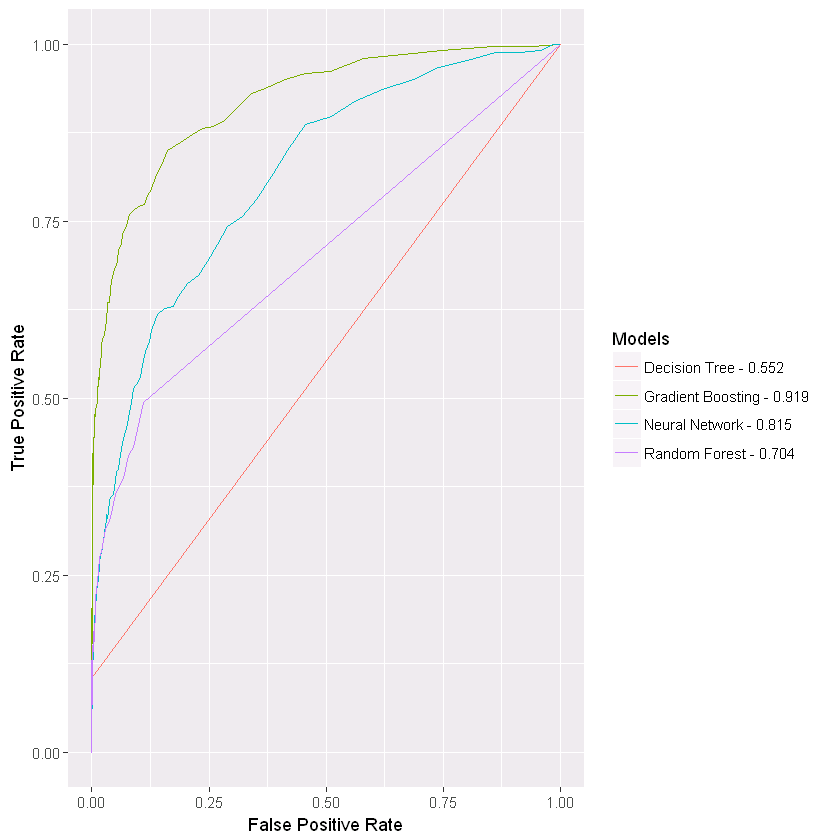

In [284]:
# Add a new column to be used as the ROC curve label
df_assess$Models <- paste(df_assess$Model, round(df_assess$'_C_', 3), sep = ' - ')

#Subset the data frame with only three variables 
df_roc = df_assess[c('_FPR_', '_Sensitivity_', 'Models')]
colnames(df_roc) = c("FPR", "Sensitivity", "Models")

# Create the ROC curve
ggplot(data = newdf, 
       aes(x = FPR, y = Sensitivity, colour = Models)) + geom_line() +
       labs(x = 'False Positive Rate', y = 'True Positive Rate')

# Alternative code using Functions and Looping

In [285]:
# # Score the models
# models <- c('dt','rf','gbt','nn')
# scores <- c(cas.decisionTree.dtreeScore, cas.decisionTree.forestScore, cas.decisionTree.gbtreeScore, cas.neuralNet.annScore)
# names(scores) <- models

# # Function to help automate prediction process on new data
# score.params <- function(model){return(list(
#     object       = defCasTable(conn, indata),
#     modelTable   = list(name = paste0(model, '_model')),
#     copyVars     = list(target, '_PartInd_'),
#     assessonerow = TRUE,
#     casOut       = list(name = paste0(model, '_scored'), replace = T)
# ))}
# lapply(models, function(x) {do.call(scores[[x]], score.params(x))})

# # Useful function for model assessment
# assess.model <- function(model){
#     cas.percentile.assess(conn,
#         table    = list(name = paste0(model,'_scored'), where = '_PartInd_ = 0'),
#         inputs   = paste0('_', model, '_P_           1'),
#         response = target,
#         event    = '1')
# }

# model.names <- c('Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network')
# roc.df <- data.frame()
# for (i in 1:length(models)){
#     tmp <- (assess.model(models[i]))$ROCInfo
#     tmp$Model <- model.names[i] 
#     roc.df <- rbind(roc.df, tmp)
# }

# # Manipulate the dataframe
# compare <- subset(roc.df, CutOff == 0.5)
# rownames(compare) <- NULL
# compare[,c('Model','TP','FP','FN','TN')]

# # Add a new column to be used as the ROC curve label
# roc.df$Models <- paste(roc.df$Model, round(roc.df$C, 3), sep = ' - ')

# # Create the ROC curve
# ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Models')], 
#        aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Models)) + geom_line() +
#        labs(x = 'False Positive Rate', y = 'True Positive Rate')

## Fit an XGBoost Model in R Locally

In [286]:
# Bring data locally and make sure it's in the right format
df <- to.casDataFrame(defCasTable(conn, indata), obs = nrow(castbl))
df <- df[,c(target, inputs, '_PartInd_')]
    
# Create dummy variables through one-hot encoding
df.dum <- df[,nominals[-1]]
dummies <- dummyVars('~ .', data = df.dum)
df.ohe <- as.data.frame(predict(dummies, newdata = df))
df.all.combined <- cbind(df[,-c(which(colnames(df) %in% nominals[-1]))], df.ohe)

# Split into training and validation
train <- df.all.combined[df.all.combined['_PartInd_'] == 1,]
valid <- df.all.combined[df.all.combined['_PartInd_'] == 0,]

# Train the XGBoost model
set.seed(101112)
bst <- xgboost(
    data = data.matrix(train[,-1]),
    label = data.matrix(train[,1]),
    missing = 'NAN',
    nround = 25,
    objective = "binary:logistic",
    eta = 0.1,
    max_depth = 5,  
    subsample = 0.5,
    colsample_bytree = 0.5
)

[1]	train-error:0.179051 
[2]	train-error:0.137105 
[3]	train-error:0.134708 
[4]	train-error:0.136146 
[5]	train-error:0.124880 
[6]	train-error:0.113375 
[7]	train-error:0.116731 
[8]	train-error:0.109779 
[9]	train-error:0.107143 
[10]	train-error:0.109060 
[11]	train-error:0.102589 
[12]	train-error:0.104506 
[13]	train-error:0.099952 
[14]	train-error:0.100911 
[15]	train-error:0.103547 
[16]	train-error:0.100911 
[17]	train-error:0.102349 
[18]	train-error:0.100671 
[19]	train-error:0.098993 
[20]	train-error:0.098035 
[21]	train-error:0.096836 
[22]	train-error:0.094439 
[23]	train-error:0.091083 
[24]	train-error:0.091083 
[25]	train-error:0.091323 


## Score and Assess XGBoost on Validation Data

In [287]:
# Create a dataframe with the misclassification rate for XGBoost
pred <- as.numeric(predict(bst, data.matrix(valid[,-1]), missing = 'NAN') > 0.5)
Misclassification <- mean(as.numeric(pred > 0.5) != valid[,1])
xgb <- data.frame(cbind(Model = 'R - XGBoost', Misclassification))
xgb

Model,Misclassification
R - XGBoost,0.106263982102908


## Final Assessment with CAS and R Models

In [288]:
# Combine the assessments and order by most accurate on validation data
err <- data.frame(rbind(miss, xgb))
err[,-1] <- round(as.numeric(as.character(err[,-1])),7)
err <- err[order(err[,-1]),]
rownames(err) <- NULL
err

Model,Misclassification
Gradient Boosting,0.1017897
R - XGBoost,0.1062640
Neural Network,0.1543624
Random Forest,0.1722595
Decision Tree,0.1733781


## Save the CAS Gradient Boosting Model

In [289]:
# Save the champion model for later use
cas.table.save(conn, table = list(name = 'gbt_model'), name = 'Best_Model_gbt', replace = T)

NOTE: Cloud Analytic Services saved the file Best_Model_gbt.sashdat in caslib CASUSER(student).


$caslib
[1] "CASUSER(student)"

$name
[1] "Best_Model_gbt.sashdat"

## End the Session

In [290]:
cas.session.endSession(conn)

list()